# Ensemble Evaluation: Timepoint 2 - Summer 2021

Location: New York State

Timepoint 2: July 15, 2021. Setting: New York State upon the arrival of the Delta variant. Vaccines available.

## Set up for ensemble modeling

### Load dependencies

In [1]:
from pyciemss.utils.ensemble_eval_utils import * 

### Collect relevant models
<!-- We have chosen x number of models to capture the relevant COVID-19 dynamics for this setting. 
 - `model1` contains compartments SEIRHD, and is stratified by age into four groups.
 - `model2` is the same as `model1`, but allows for reinfection
 - `model3` is the same as `model1`, but with a variation in transmission rate to account for masking efficacy and compliance. -->

In [6]:
model1 = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_forT2.json"
model2 = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v2_forT2.json"
model3 = "../../notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v3_forT2.json"

# from mira.sources.askenet import model_from_url
# model1 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_forT2.json')
# model2 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v2_forT2.json')
# model3 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v3_forT2.json')

### Gather source data and set `DATA_PATH`, `RESULTS_PATH`

In [3]:
url = 'https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/milestone_12month/evaluation/ensemble_eval_SA/datasets/aabb3684-a7ea-4f60-98f1-a8e673ad6df5/dataset.csv'
nys_data = pd.read_csv(url)
nys_data["E"] = np.nan # Add empty "E" column so that "exposed" may be used to post-process results
nys_data["I0"] = np.nan
nys_data["I1"] = np.nan
nys_data["I2"] = np.nan
nys_data["I3"] = np.nan
nys_data["H0"] = np.nan
nys_data["H1"] = np.nan
nys_data["H2"] = np.nan
nys_data["H3"] = np.nan

DATA_PATH = "../../notebook/ensemble_eval_sa/datasets/"
RESULTS_PATH = "../../notebook/ensemble_eval_sa/ensemble_results/"
FIGURE_PATH = "../../notebook/ensemble_eval_sa/figures/"

### Create and save datasets and simulation timepoints for each forecast

In [4]:
### Forecast 1: 07/15/2021 - 08/12/2021, data: 05/01/2021 - 08/11/2021

# Forecast 1: 07/15/2021 (day 75, row 541) - 08/12/2021 (day 103, row 569), train data: 05/01/2021 (day 0, row 466) - 07/14/2021 (day 74, row 540)
[all_data1, train_data1, timepoints1] = data_selector_function(nys_data, 465, 540, 569)
train_data1[["I", "E", "H", "D", "I0", "I1", "I2", "I3", "H0", "H1", "H2", "H3"]].to_csv(DATA_PATH + "NYS_T2_forecast1.csv")

### Forecast 2: 07/22/2021 - 08/19/2021, data: 05/01/2021 - 07/21/2021

# Forecast 2: 07/22/2021 (day 82, row 548) - 08/19/2021 (day 110, row 576), train data: 05/01/2021 (day 0, row 466) - 07/21/2021 (day 81, row 547)
[all_data2, train_data2, timepoints2] = data_selector_function(nys_data, 465, 547, 576)
train_data2[["I", "E", "H", "D", "I0", "I1", "I2", "I3", "H0", "H1", "H2", "H3"]].to_csv(DATA_PATH + "NYS_T2_forecast2.csv")

### Forecast 3: 07/29/2021 - 08/26/2021, data: 05/01/2021 - 07/28/2021

# Forecast 3: 07/29/2021 (day 89, row 555) - 08/26/2021 (day 117, row 583), train data: 05/01/2021 (day 0, row 466) - 07/28/2021 (day 88, row 554)
[all_data3, train_data3, timepoints3] = data_selector_function(nys_data, 465, 554, 583)
train_data3[["I", "E", "H", "D", "I0", "I1", "I2", "I3", "H0", "H1", "H2", "H3"]].to_csv(DATA_PATH + "NYS_T2_forecast3.csv")

### Forecast 4: 08/05/2021 - 09/02/2021, data: 05/01/2021 - 08/04/2021

# Forecast 4: 08/05/2021 (day 96, row 562) - 09/02/2021 (day 124, row 590), train data: 05/01/2021 (day 0, row 466) - 08/04/2021 (day 95, row 561)
[all_data4, train_data4, timepoints4] = data_selector_function(nys_data, 465, 561, 590)
train_data4[["I", "E", "H", "D", "I0", "I1", "I2", "I3", "H0", "H1", "H2", "H3"]].to_csv(DATA_PATH + "NYS_T2_forecast4.csv")

### Plot the data

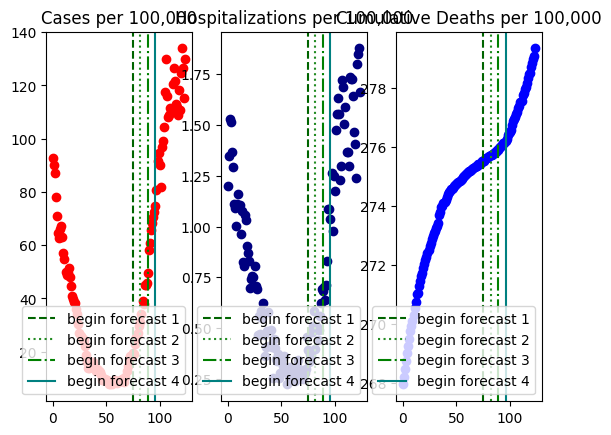

In [5]:
nys_pop = {
    "total": 19_340_000,
    "A0": 4597368.0, # New York State population aged 0 - 19
    "A1": 7893559.0, # New York State population aged 20 - 49
    "A2": 3878809.0, # New York State population aged 50 - 64
    "A3": 2970264.0, # New York State population aged 65+ 
}
N = nys_pop["total"]
plt = plot_case_hosp_death_data(N, all_data4, forecast1_start=75, forecast2_start=82, forecast3_start=89, forecast4_start=96)
plt.savefig(FIGURE_PATH + "T2data.png")

# (1) Forecast 1: 07/15/2021 - 08/12/2021

## (A) Calibrate and sample an ensemble of one model

In [157]:
# RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of3_results_Jul152021.csv"
# QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of3_quantiles_Jul152021.csv"
N_ITERATIONS = 250

### MODEL 1 - SEIRHD with NPI of Type 1

In [160]:
num_samples = 100
models = [model1]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "I", "E": "E", "H": "H", "D": "D"}]

# Run the calibration and sampling
result1A1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A1["data"]), keep="I.*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "T2results1A1.json")
plots.ipy_display(schema)

iteration 0: loss = 2288.8344549536705
iteration 25: loss = 2281.8126577734947
iteration 50: loss = 2278.8557712435722
iteration 75: loss = 2277.366808593273
iteration 100: loss = 2277.4500626921654
iteration 125: loss = 2275.785573422909
iteration 150: loss = 2275.324844300747
iteration 175: loss = 2276.23337072134
iteration 200: loss = 2274.628257930279
iteration 225: loss = 2274.8000254034996



In [161]:
result1A1["data"]

,timepoint_id,sample_id,model_0/beta_c_param,model_0/kappa_param,model_0/eta_param,model_0/gamma_param,model_0/mu_param,model_0_weight,model_0/N_param,model_0/beta_s_param,model_0/k_param,model_0/t_0_param,model_0/delta_param,model_0/los_param,I_sol,E_sol,H_sol,D_sol,timepoint_days
0,0,0,2.369720,0.203374,0.039050,0.325835,0.231785,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17934.000000,18000.000000,232.000000,51819.000000,0.0
1,1,0,2.369720,0.203374,0.039050,0.325835,0.231785,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17800.570312,17899.607422,249.913879,51820.117188,0.1
2,2,0,2.369720,0.203374,0.039050,0.325835,0.231785,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17668.953125,17799.146484,267.306183,51821.308594,0.2
3,3,0,2.369720,0.203374,0.039050,0.325835,0.231785,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17539.076172,17698.626953,284.189270,51822.593750,0.3
4,4,0,2.369720,0.203374,0.039050,0.325835,0.231785,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17410.894531,17598.105469,300.575592,51823.949219,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103095,1026,99,2.365589,0.190534,0.133904,0.285082,0.187410,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,5346.056152,7395.942383,782.448669,54705.382812,102.6
103096,1027,99,2.365589,0.190534,0.133904,0.285082,0.187410,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,5378.645996,7440.988281,787.221985,54708.328125,102.7
103097,1028,99,2.365589,0.190534,0.133904,0.285082,0.187410,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,5411.436035,7486.310547,792.024658,54711.285156,102.8
103098,1029,99,2.365589,0.190534,0.133904,0.285082,0.187410,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,5444.421387,7531.903320,796.856262,54714.265625,102.9


In [156]:
schema = plots.trajectories(pd.DataFrame(result1A1["data"]), keep="I.*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "T2results1A1.json")
plots.ipy_display(schema)

result1A1["data"]

,timepoint_id,sample_id,model_0/beta_c_param,model_0/kappa_param,model_0/eta_param,model_0/gamma_param,model_0/mu_param,model_0_weight,model_0/N_param,model_0/beta_s_param,model_0/k_param,model_0/t_0_param,model_0/delta_param,model_0/los_param,I_sol,E_sol,H_sol,D_sol,timepoint_days
0,0,0,2.370510,0.193520,0.047357,0.279685,0.306724,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17934.000000,18000.000000,232.000000,51819.000000,0.0
1,1,0,2.370510,0.193520,0.047357,0.279685,0.306724,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17881.683594,17883.691406,250.889526,51820.480469,0.1
2,2,0,2.370510,0.193520,0.047357,0.279685,0.306724,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17827.962891,17769.275391,269.335602,51822.085938,0.2
3,3,0,2.370510,0.193520,0.047357,0.279685,0.306724,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17772.921875,17656.666016,287.345581,51823.859375,0.3
4,4,0,2.370510,0.193520,0.047357,0.279685,0.306724,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,17716.662109,17545.851562,304.924683,51825.601562,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103095,1026,99,2.371834,0.191899,0.063225,0.290895,0.284556,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,4499.726562,6310.262695,318.625549,53852.511719,102.6
103096,1027,99,2.371834,0.191899,0.063225,0.290895,0.284556,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,4526.655762,6348.020020,320.534088,53854.375000,102.7
103097,1028,99,2.371834,0.191899,0.063225,0.290895,0.284556,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,4553.760254,6386.001953,322.454559,53856.203125,102.8
103098,1029,99,2.371834,0.191899,0.063225,0.290895,0.284556,1.0,19340000.0,1.0,5.0,64.0,0.25,5.0,4581.024414,6424.206055,324.386322,53858.042969,102.9


### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of1_results_Jul152020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of1_quantiles_Jul152020.csv"

# Define functions to get incident cases, hospitalizations, and deaths
def get_incident_cases(delta, exposed): # delta * Exposed
    return delta * exposed

def get_incident_hosp(eta, gamma, infectious): # eta * gamma * Infectious
    return eta * gamma * infectious

def get_incident_deaths(mu, los, hospitalized): # (mu/los) * Hospitalized
    return (mu/los) * hospitalized

results_df = result1A1["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints1, train_data1, "2021-07-14", "New York State")

### MODEL 2 - Age-Structured SEIRHD with NPI of Type I, Model Version 2

In [ ]:
num_samples = 100
models = [model2]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "T2results1A12.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
# results_df = result1A2["data"]
# results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
# results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
# results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)

# # Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
# process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints1, train_data1, "2021-07-14", "New York State")

### MODEL 3 - Age-Structured SEIRHD with NPI of Type I, Model Version 3

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A3 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A3["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "T2results1A3.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
# results_df = result1A3["data"]
# results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
# results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
# results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)

# # Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
# process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints1, train_data1, "2021-07-14", "New York State")

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "I", "E": "E", "H": "H", "D": "D"},
                     {"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}, 
                     {"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}
                     ]

# Run the calibration and sampling
result1B1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B1["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "T2results1B1.json")
plots.ipy_display(schema)

In [ ]:
num_samples = 100
models = [model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast1.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}, 
                     {"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}
                     ]

# Run the calibration and sampling
result1B2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT21B2.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of2_results_Jul152021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of2_quantiles_Jul152021.csv"
# result1B3["data"].keys()

# Define functions to get incident cases, hospitalizations, and deaths
def get_incident_cases_ensemble2(weight0, delta0, weight1, delta1, exposed): # delta * Exposed
    return (weight0*delta0 + weight1*delta1) * exposed

def get_incident_hosp_ensemble2(weight0, eta00, eta01, eta02, eta03, gamma0, 
                                   weight1, eta10, eta11, eta12, eta13, gamma1, I0, I1, I2, I3): # eta * gamma * Infectious
    inc_hosp = ((weight0 * gamma0 * eta00 + weight1 * gamma1 * eta10) * I0 
        + (weight0 * gamma0 * eta01 + weight1 * gamma1 * eta11) * I1 
        + (weight0 * gamma0 * eta02 + weight1 * gamma1 * eta12) * I2 
        + (weight0 * gamma0 * eta03 + weight1 * gamma1 * eta13) * I3)
    return inc_hosp

def get_incident_deaths_ensemble2(weight0, mu00, mu01, mu02, mu03, los00, los01, los02, los03, 
                                   weight1, mu10, mu11, mu12, mu13, los10, los11, los12, los13, H0, H1, H2, H3): # (mu/los) * Hospitalized
    inc_deaths = ((weight0 * (mu00 / los00) + weight1 * (mu10 / los10)) * H0 
        + (weight0 * (mu01 / los01) + weight1 * (mu11 / los11)) * H1 
        + (weight0 * (mu02 / los02) + weight1 * (mu12 / los12)) * H2  
        + (weight0 * (mu03 / los03) + weight1 * (mu13 / los13)) * H3) 
    return inc_deaths

results_df = result1B2["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases_ensemble2(row['model_0_weight'], row['model_0/delta_param'], 
                                                                                            row['model_1_weight'], row['model_1/delta_param'], row['E_sol']), axis=1)

results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp_ensemble2(row['model_0_weight'], row['model_0/eta_0_param'], row['model_0/eta_1_param'], row['model_0/eta_2_param'], 
                                                                                          row['model_0/eta_3_param'], row['model_0/gamma_param'],  
                                                                                          row['model_1_weight'], row['model_1/eta_0_param'], row['model_1/eta_1_param'], row['model_1/eta_2_param'], row['model_1/eta_3_param'], 
                                                                                          row['model_1/gamma_param'], row['I0_sol'], row['I1_sol'], row['I2_sol'], row['I3_sol']), axis=1)

results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths_ensemble2(row['model_0_weight'], row['model_0/mu_0_param'], row['model_0/mu_1_param'], row['model_0/mu_2_param'], 
                                                                                          row['model_0/mu_3_param'], row['model_0/los_0_param'], row['model_0/los_1_param'], row['model_0/los_2_param'], row['model_0/los_3_param'],  
                                                                                          row['model_1_weight'], row['model_1/mu_0_param'], row['model_1/mu_1_param'], row['model_1/mu_2_param'], row['model_1/mu_3_param'], 
                                                                                          row['model_1/los_0_param'], row['model_1/los_1_param'], row['model_1/los_2_param'], row['model_1/los_3_param'], 
                                                                                          row['H0_sol'], row['H1_sol'], row['H2_sol'], row['H3_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints1, train_data1, "2021-07-14", "New York State")

# (2) Forecast 2: 07/22/2021 - 08/19/2021

## (A) Calibrate and sample an ensemble of one model

In [ ]:
N_ITERATIONS = 300
num_samples = 100
models = [model1]
data_location = DATA_PATH + "NYS_T2_forecast2.csv"
weights = [1]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result2A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2A["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT22A.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of1_results_Jul222021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of1_quantiles_Jul222021.csv"

results_df = result2A["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints2, train_data2, "2021-07-21", "New York State")

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast2.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}, 
                     {"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}
                     ]

# Run the calibration and sampling
result2B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2B["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT22B.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of2_results_Jul222021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of2_quantiles_Jul222021.csv"

results_df = result2B["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases_ensemble2(row['model_0_weight'], row['model_0/delta_param'], 
                                                                                            row['model_1_weight'], row['model_1/delta_param'], row['E_sol']), axis=1)

results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp_ensemble2(row['model_0_weight'], row['model_0/eta_0_param'], row['model_0/eta_1_param'], row['model_0/eta_2_param'], 
                                                                                          row['model_0/eta_3_param'], row['model_0/gamma_param'],  
                                                                                          row['model_1_weight'], row['model_1/eta_0_param'], row['model_1/eta_1_param'], row['model_1/eta_2_param'], row['model_1/eta_3_param'], 
                                                                                          row['model_1/gamma_param'], row['I0_sol'], row['I1_sol'], row['I2_sol'], row['I3_sol']), axis=1)

results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths_ensemble2(row['model_0_weight'], row['model_0/mu_0_param'], row['model_0/mu_1_param'], row['model_0/mu_2_param'], 
                                                                                          row['model_0/mu_3_param'], row['model_0/los_0_param'], row['model_0/los_1_param'], row['model_0/los_2_param'], row['model_0/los_3_param'],  
                                                                                          row['model_1_weight'], row['model_1/mu_0_param'], row['model_1/mu_1_param'], row['model_1/mu_2_param'], row['model_1/mu_3_param'], 
                                                                                          row['model_1/los_0_param'], row['model_1/los_1_param'], row['model_1/los_2_param'], row['model_1/los_3_param'], 
                                                                                          row['H0_sol'], row['H1_sol'], row['H2_sol'], row['H3_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints2, train_data2, "2021-07-21", "New York State")

# (3) Forecast 3: 07/29/2021 - 08/26/2021

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model1]
data_location = DATA_PATH + "NYS_T2_forecast3.csv"
weights = [1]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result3A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3A["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT23A.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of1_results_Jul292021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of1_quantiles_Jul292021.csv"

results_df = result3A["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints3, train_data3, "2021-07-28", "New York State")

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast3.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}, 
                     {"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}
                     ]

# Run the calibration and sampling
result3B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3B["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT23B.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of2_results_Jul292021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of2_quantiles_Jul292021.csv"

results_df = result3B["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases_ensemble2(row['model_0_weight'], row['model_0/delta_param'], 
                                                                                            row['model_1_weight'], row['model_1/delta_param'], row['E_sol']), axis=1)

results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp_ensemble2(row['model_0_weight'], row['model_0/eta_0_param'], row['model_0/eta_1_param'], row['model_0/eta_2_param'], 
                                                                                          row['model_0/eta_3_param'], row['model_0/gamma_param'],  
                                                                                          row['model_1_weight'], row['model_1/eta_0_param'], row['model_1/eta_1_param'], row['model_1/eta_2_param'], row['model_1/eta_3_param'], 
                                                                                          row['model_1/gamma_param'], row['I0_sol'], row['I1_sol'], row['I2_sol'], row['I3_sol']), axis=1)

results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths_ensemble2(row['model_0_weight'], row['model_0/mu_0_param'], row['model_0/mu_1_param'], row['model_0/mu_2_param'], 
                                                                                          row['model_0/mu_3_param'], row['model_0/los_0_param'], row['model_0/los_1_param'], row['model_0/los_2_param'], row['model_0/los_3_param'],  
                                                                                          row['model_1_weight'], row['model_1/mu_0_param'], row['model_1/mu_1_param'], row['model_1/mu_2_param'], row['model_1/mu_3_param'], 
                                                                                          row['model_1/los_0_param'], row['model_1/los_1_param'], row['model_1/los_2_param'], row['model_1/los_3_param'], 
                                                                                          row['H0_sol'], row['H1_sol'], row['H2_sol'], row['H3_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints3, train_data3, "2021-07-28", "New York State")

# (4) Forecast 4: 08/05/2021 - 09/02/2021

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T2_forecast4.csv"
weights = [1]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}]

# Run the calibration and sampling
result4A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4A["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT24A.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of1_results_Aug052021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of1_quantiles_Aug052021.csv"

# Define functions to get incident cases, hospitalizations, and deaths
def get_incident_cases01(delta, exposed): # delta * Exposed
    return delta * exposed

def get_incident_hosp01(eta0, eta1, eta2, eta3, gamma, I0, I1, I2, I3): # eta * gamma * Infectious
    return gamma * (eta0 * I0 + eta1 * I1 + eta2 * I2 + eta3 * I3)

def get_incident_deaths01(mu0, mu1, mu2, mu3, los0, los1, los2, los3, H0, H1, H2, H3): # (mu/los) * Hospitalized
    return (mu0 / los0) * H0 + (mu1 / los1) * H1 + (mu2 / los2) * H2 + (mu3 / los3) * H3

results_df = result4A["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases01(row['model_0/delta_param'], row['E_sol']), axis=1)

results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp01(row['model_0/eta_0_param'], row['model_0/eta_1_param'], row['model_0/eta_2_param'], row['model_0/eta_3_param'], 
                                                                                          row['model_0/gamma_param'], row['I0_sol'], row['I1_sol'], row['I2_sol'], row['I3_sol']), axis=1)

results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths01(row['model_0/mu_0_param'], row['model_0/mu_1_param'], row['model_0/mu_2_param'], row['model_0/mu_3_param'], 
                                                                                     row['model_0/los_0_param'], row['model_0/los_1_param'], row['model_0/los_2_param'], row['model_0/los_3_param'],  
                                                                                     row['H0_sol'], row['H1_sol'], row['H2_sol'], row['H3_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints4, train_data4, "2021-08-04", "New York State")

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model2, model3]
data_location = DATA_PATH + "NYS_T2_forecast4.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}, 
                     {"I": "infected", "E": "exposed", "H": "hospitalized", "D": "dead", "I0": "I0", "I1": "I1", "I2": "I2", "I3": "I3", "H0": "H0", "H1": "H1", "H2": "H2", "H3": "H3"}
                     ]

# Run the calibration and sampling
result4B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4B["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, FIGURE_PATH + "resultsT24B.json")
plots.ipy_display(schema)

### Post-process and save results, formatted quantiles

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T2_ensemble_of2_results_Aug052021.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T2_ensemble_of2_quantiles_Aug052021.csv"

results_df = result4B["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases_ensemble2(row['model_0_weight'], row['model_0/delta_param'], 
                                                                                            row['model_1_weight'], row['model_1/delta_param'], row['E_sol']), axis=1)

results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp_ensemble2(row['model_0_weight'], row['model_0/eta_0_param'], row['model_0/eta_1_param'], row['model_0/eta_2_param'], 
                                                                                          row['model_0/eta_3_param'], row['model_0/gamma_param'],  
                                                                                          row['model_1_weight'], row['model_1/eta_0_param'], row['model_1/eta_1_param'], row['model_1/eta_2_param'], row['model_1/eta_3_param'], 
                                                                                          row['model_1/gamma_param'], row['I0_sol'], row['I1_sol'], row['I2_sol'], row['I3_sol']), axis=1)

results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths_ensemble2(row['model_0_weight'], row['model_0/mu_0_param'], row['model_0/mu_1_param'], row['model_0/mu_2_param'], 
                                                                                          row['model_0/mu_3_param'], row['model_0/los_0_param'], row['model_0/los_1_param'], row['model_0/los_2_param'], row['model_0/los_3_param'],  
                                                                                          row['model_1_weight'], row['model_1/mu_0_param'], row['model_1/mu_1_param'], row['model_1/mu_2_param'], row['model_1/mu_3_param'], 
                                                                                          row['model_1/los_0_param'], row['model_1/los_1_param'], row['model_1/los_2_param'], row['model_1/los_3_param'], 
                                                                                          row['H0_sol'], row['H1_sol'], row['H2_sol'], row['H3_sol']), axis=1)

# Save processed results
# results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints4, train_data4, "2021-08-04", "New York State")